TensorFlow is a powerful library for numerical computation, particularly well suited and fine-tuned for large–scale Machine Learning ( but you could use it for anything else that requires heavy calculations). The Google Brain team developed it, and it powers many of Google’s large-scale services, such as Google cloud speech, Google Photos, and Google Search.

It was open-sourced in November 2015, and it is now the most popular Deep Learning library (in terms of citations in papers, adoption in companies, stars on GitHub, etc.). Countless projects use Tensorflow for all sorts of Machine Learning tasks, such as image classification, natural language processing, recommender systems, and time series forecasting.

### Features of TensorFlow

* Its core is very similar to Numpy, but with GPU support.
* It supports distributed computing (across multiple devices and servers).
* It includes a kind of just –in –time (JIT) Compiler that allows it to optimize computations for speed and memory usage. It works by extracting the computation graph from a python function, then optimizing it (e.g., by pruning unused nodes), and finally running it efficiently (e.g., by automatically running independent operations in parallel).
* Computation graphs can be exported to a portable format so that you can train a Tensorflow model in one environment (e.g., using python on Linux) and run it in another (e.g., using java on an Android device).
* It implements auto diff (see chapter 10 and Appendix D) and provides some excellent optimizers, such as RMSProp and Nadam, to quickly minimize all sorts of loss functions.

TensorFlow offers many more features built on top of these core features; the most important is, of course, `tf.keras`, but it also has data loading and preprocessing ops (`tf.data`, `tf. Io`, etc.), image processing ops (`tf.image`), signal processing ops (`tf.signal`), and more.

### TensorFlow 
Before moving forward, we will import some libraries, that we need to operate with TensorFlow.

In [5]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
# assert tf.__version__ &gt;= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
# tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
tf.enable_eager_execution()
tf.executing_eagerly()

True

The API of TensorFlow revolves around tensors, which flow from operation to operation, hence the name TensorFlow. A tensor is usually a multidimensional array (exactly like a numpy ndarray), but it can hold a scalar (a simple value such as 42). These tensors will be important when we create custom cost functions, custom metrics, custom layers, and more, so let’s see how to create and manipulate them.

### Tensors and Operations
We can create a tensor with `tf.constant()`. For example, here is a tensor representing a matrix with two rows and three columns of floats:

In [7]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix

<tf.Tensor: id=0, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [8]:
tf.constant(42) # scalar

<tf.Tensor: id=2, shape=(), dtype=int32, numpy=42>

Just like an ndarray, a tf.Tensor has a shape and data type (dtype):

In [9]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t.shape

TensorShape([Dimension(2), Dimension(3)])

In [10]:
t.dtype

tf.float32

Indexing works much like in Numpy:

In [11]:
t[:, 1:]

<tf.Tensor: id=8, shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [12]:
t[..., 1, tf.newaxis]

<tf.Tensor: id=13, shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

Most importantly, all sorts of tensor operations are available:

In [13]:
t + 10

<tf.Tensor: id=16, shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [14]:
tf.square(t)

<tf.Tensor: id=18, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [15]:
t @ tf.transpose(t)

<tf.Tensor: id=22, shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### Tensors and NumPy
Tensors play nice with NumPy: we can create a tensor from a NumPy array, and vice versa. You can even apply TensorFlow operations to NumPy arrays and NumPy operations to tensors:

In [16]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: id=24, shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [18]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [19]:
tf.square(a)

<tf.Tensor: id=28, shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [20]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

Notice that NumPy uses 64-bit precision by default, while TensorFlow uses 32-bit. This is because 32-bit precision is generally ,more than enough for neural networks, plus it runs faster and uses less RAM. So when we create a tensor from a NumPy array, make sure to set dtype=tf.float32.

### Customizing Models and Training Algorithms in TensorFlow
Let’s start by creating a custom loss function, which is a simple common use case. We will start by loading and preparing the California housing dataset. We will first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Custom Loss Functions
Suppose we want to train a regression model, but our training set is a bit noisy. Of course, we start by trying to clean up our dataset by removing or fixing the outliers, but that turns out to be insufficient, our dataset is still noisy. Which loss function we should use? This is probably the best time to use the **Huber loss instead of the good MSE**.

The Huber loss is not currently part of the official Keras API but is available in `tf.keras`. But let’s pretend it’s not there. Just create a function that takes the labels and predictions as arguments, and use TensorFlow operations to compute every instance’s loss:

In [26]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

Now, lets visualize our model after the Huber loss function:

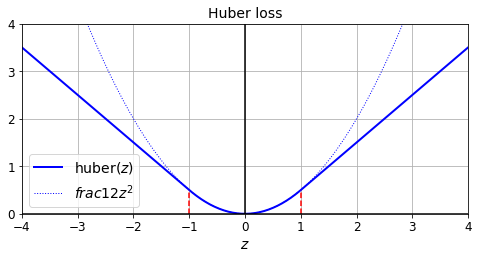

In [27]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

Now we can use the Huber loss function when we compile the keras model, then train our model:

In [28]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Instructions for updating:
Colocations handled automatically by placer.
Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 4s 327us/sample - loss: 0.3991 - mean_absolute_error: 0.7198 - val_loss: 0.2590 - val_mean_absolute_error: 0.5478
Epoch 2/2
11610/11610 [==============================] - 1s 80us/sample - loss: 0.1975 - mean_absolute_error: 0.4842 - val_loss: 0.1912 - val_mean_absolute_error: 0.4690


### Saving and Loading Tensorflow Models
Saving a model containing a custom loss function works fine, as keras saves the name of the function. Whenever we load it, we will need to provide a dictionary that maps the function name to the actual function. More generally, when we load a model containing objects, we need to map the names of the objects:

In [30]:
model.save("my_model_with_a_custom_loss.h5")

In [31]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 113us/sample - loss: 0.1888 - mean_absolute_error: 0.4717 - val_loss: 0.2013 - val_mean_absolute_error: 0.4772
Epoch 2/2
11610/11610 [==============================] - 1s 83us/sample - loss: 0.1847 - mean_absolute_error: 0.4660 - val_loss: 0.1914 - val_mean_absolute_error: 0.4676


With the current implementations, any error between -1 and 1 is considered **small**. But what if we want a different threshold? One solution to create a function that creates a configured loss function:

In [34]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [35]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [36]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 2s 161us/sample - loss: 0.2034 - mean_absolute_error: 0.4634 - val_loss: 0.2514 - val_mean_absolute_error: 0.4704
Epoch 2/2
11610/11610 [==============================] - 1s 114us/sample - loss: 0.2005 - mean_absolute_error: 0.4580 - val_loss: 0.2168 - val_mean_absolute_error: 0.4532


In [38]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [39]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [40]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 2s 180us/sample - loss: 0.1964 - mean_absolute_error: 0.4521 - val_loss: 0.2063 - val_mean_absolute_error: 0.4511
Epoch 2/2
11610/11610 [==============================] - 1s 83us/sample - loss: 0.1926 - mean_absolute_error: 0.4477 - val_loss: 0.2475 - val_mean_absolute_error: 0.4608
